<a href="https://colab.research.google.com/github/juhumkwon/DeepLearning/blob/main/CL_08_05_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0: D_loss=1.4792, G_loss=0.6446


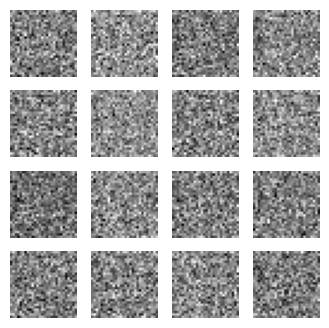

Step 1000: D_loss=1.1964, G_loss=0.7875


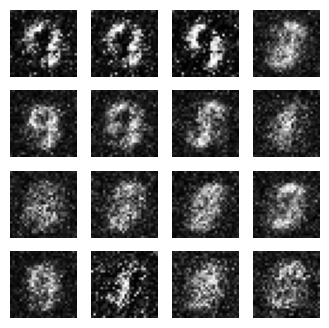

Step 2000: D_loss=1.2120, G_loss=0.9290


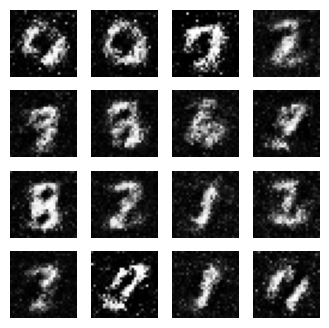

Step 3000: D_loss=1.1876, G_loss=0.8537


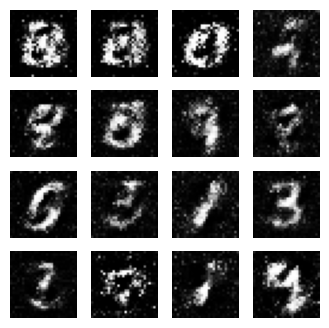

Step 4000: D_loss=1.1422, G_loss=0.8717


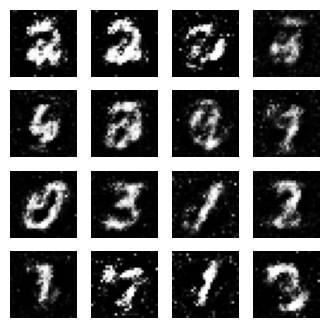

Step 5000: D_loss=1.2775, G_loss=0.8186


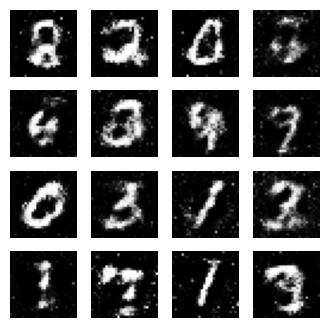

Step 6000: D_loss=1.1933, G_loss=0.8873


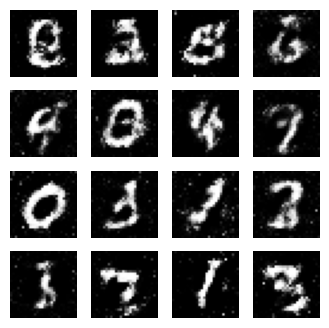

Step 7000: D_loss=1.2097, G_loss=0.8636


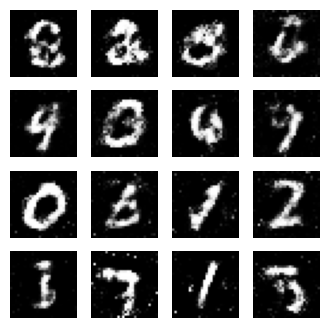

Step 8000: D_loss=1.2448, G_loss=0.8268


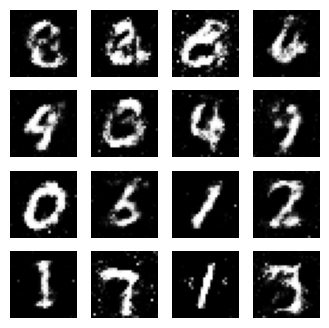

Step 9000: D_loss=1.3419, G_loss=0.8300


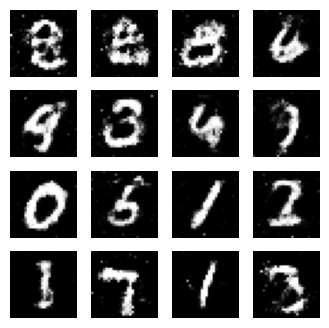

Step 10000: D_loss=1.2818, G_loss=0.8441


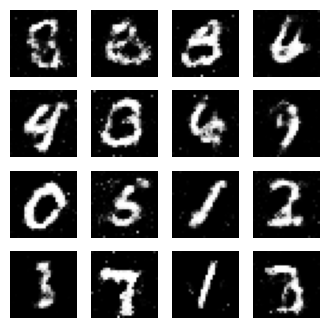

Step 11000: D_loss=1.3127, G_loss=0.7961


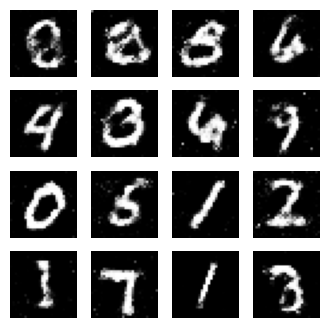

Step 12000: D_loss=1.3364, G_loss=0.8058


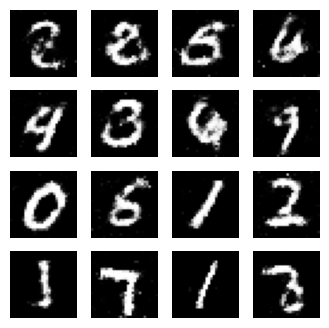

Step 13000: D_loss=1.3399, G_loss=0.8111


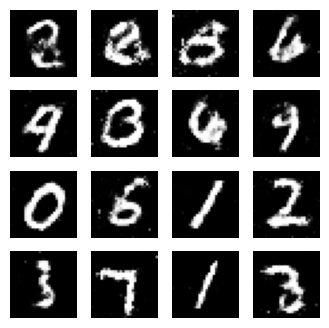

Step 14000: D_loss=1.3627, G_loss=0.8045


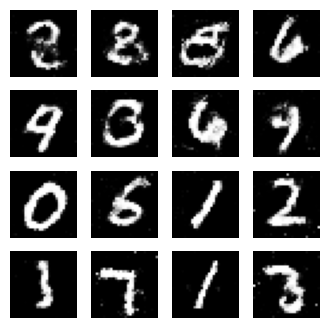

Step 15000: D_loss=1.3382, G_loss=0.7921


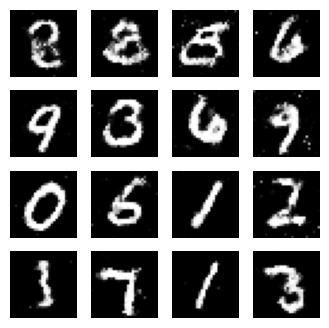

Step 16000: D_loss=1.3520, G_loss=0.7832


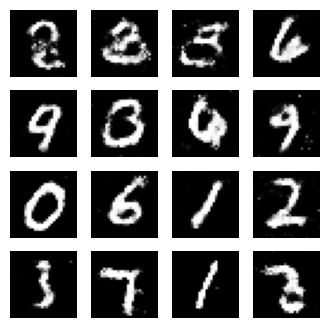

Step 17000: D_loss=1.3918, G_loss=0.7950


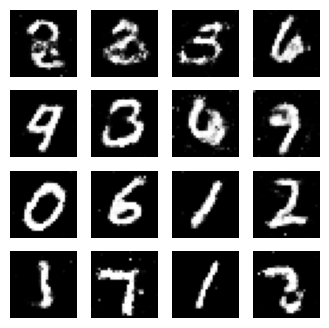

Step 18000: D_loss=1.3946, G_loss=0.8010


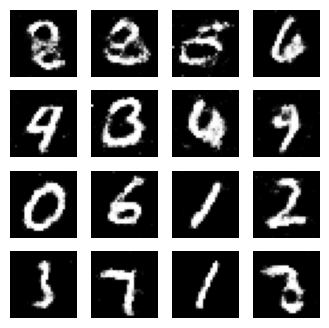

Step 19000: D_loss=1.3492, G_loss=0.7663


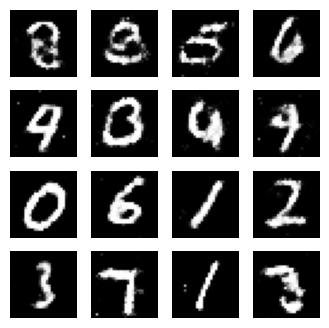

Step 20000: D_loss=1.3472, G_loss=0.7927


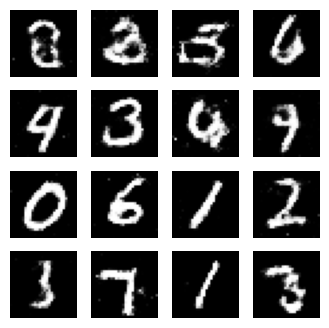

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# =====================================
# 1️⃣ 설정
# =====================================
latent_dim = 100
batch_size = 128
epochs = 20000

# =====================================
# 2️⃣ 데이터 로드 (MNIST)
# =====================================
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5  # [-1,1]
x_train = np.expand_dims(x_train, axis=-1)
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(batch_size)

# =====================================
# 3️⃣ Generator 정의 (BatchNorm 포함)
# =====================================
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=latent_dim),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Dense(512),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Dense(1024),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Dense(28*28, activation="tanh"),
        layers.Reshape((28, 28, 1))
    ])
    return model

# =====================================
# 4️⃣ Discriminator 정의 (LeakyReLU + Dropout)
# =====================================
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(512),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Dense(256),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# 모델 생성
G = build_generator()
D = build_discriminator()

# =====================================
# 5️⃣ 손실 & 옵티마이저
# =====================================
bce = tf.keras.losses.BinaryCrossentropy()
g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# =====================================
# 6️⃣ 학습 스텝
# =====================================
@tf.function
def train_step(real_imgs):
    # ① 가짜 이미지 생성
    z = tf.random.normal((batch_size, latent_dim))
    fake_imgs = G(z, training=True)

    # ② D 학습
    with tf.GradientTape() as tape_D:
        real_preds = D(real_imgs, training=True)
        fake_preds = D(fake_imgs, training=True)
        d_loss_real = bce(tf.ones_like(real_preds), real_preds)
        d_loss_fake = bce(tf.zeros_like(fake_preds), fake_preds)
        d_loss = d_loss_real + d_loss_fake
    grads_D = tape_D.gradient(d_loss, D.trainable_variables)
    d_optimizer.apply_gradients(zip(grads_D, D.trainable_variables))

    # ③ G 학습
    z = tf.random.normal((batch_size, latent_dim))
    with tf.GradientTape() as tape_G:
        fake_imgs = G(z, training=True)
        fake_preds = D(fake_imgs, training=True)
        g_loss = bce(tf.ones_like(fake_preds), fake_preds)
    grads_G = tape_G.gradient(g_loss, G.trainable_variables)
    g_optimizer.apply_gradients(zip(grads_G, G.trainable_variables))

    return d_loss, g_loss

# =====================================
# 7️⃣ 학습 루프
# =====================================
fixed_noise = tf.random.normal((16, latent_dim))

for step, real_imgs in enumerate(dataset.repeat()):
    d_loss, g_loss = train_step(real_imgs)

    # 🔹 출력 주기를 1000 step으로 줄임
    if step % 1000 == 0:
        print(f"Step {step}: D_loss={d_loss:.4f}, G_loss={g_loss:.4f}")

        # 🔹 시각화 주기 축소
        gen_imgs = G(fixed_noise, training=False)
        gen_imgs = (gen_imgs + 1.0) / 2.0  # [0,1] 복원

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(gen_imgs[i, :, :, 0], cmap="gray")
            plt.axis("off")
        plt.show()

    if step >= epochs:
        break
